# BentoML Example: Keras Fashion MNIST

[BentoML](http://bentoml.ai) is an open source platform for machine learning model serving and deployment. 

This notebook demonstrates how to use BentoML to turn a Keras model into a docker image containing a REST API server serving this model, how to use your ML service built with BentoML as a CLI tool, and how to distribute it a pypi package.

![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=keras&ea=keras-fashion-mnist&dt=keras-fashion-mnist)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install bentoml
!pip install tensorflow==1.14.0 numpy matplotlib keras

In [2]:
from __future__ import absolute_import, division, print_function

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print("Tensorflow Version: %s" % tf.__version__)

import keras
print("Keras Version: %s" % keras.__version__)

import bentoml
print("BentoML Version: %s" % bentoml.__version__)

Using TensorFlow backend.


Tensorflow Version: 1.14.0
Keras Version: 2.2.4
BentoML Version: 0.4.4


## Load Fashion MNIST dataset

In [3]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Each image is mapped to a single label. Since the class names are not included with the dataset, store them here to use later when plotting the images:

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

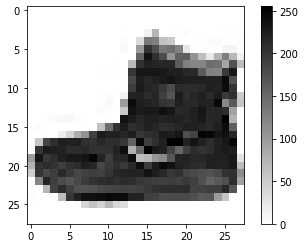

In [5]:
plt.figure()
plt.imshow(train_images[0], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

We should scale these values to a range of 0 to 1 before feeding to the neural network model. For this, we divide the values by 255. It's important that the *training set* and the *testing set* are preprocessed in the same way:

In [6]:
train_images = train_images / 255.0
test_images = test_images / 255.0

Display the first 25 images from the training set and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

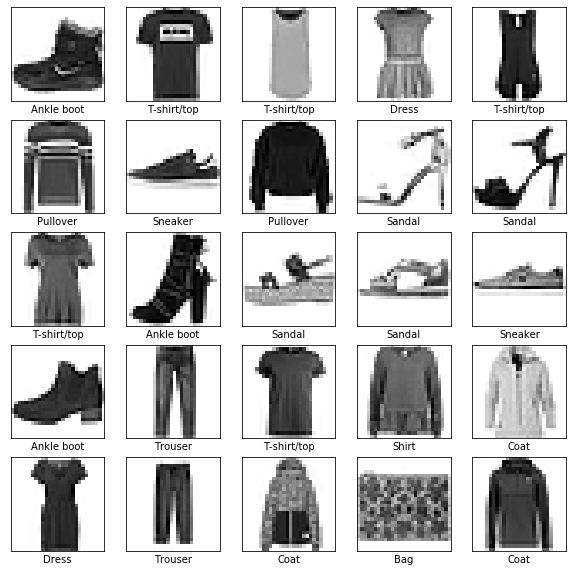

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [8]:
# Reshaping the images so that our model can accept it
train_images  = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

## Build the model

In [9]:
model = keras.Sequential()
# Must define the input shape in the first layer of the neural network
model.add(keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation='softmax'))
# Take a look at the model summary
model.summary()

W1014 17:04:00.739176 4335975744 deprecation_wrapper.py:119] From /Users/chaoyuyang/anaconda3/envs/bentoml-dev/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1014 17:04:00.752170 4335975744 deprecation_wrapper.py:119] From /Users/chaoyuyang/anaconda3/envs/bentoml-dev/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:529: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1014 17:04:00.754939 4335975744 deprecation_wrapper.py:119] From /Users/chaoyuyang/anaconda3/envs/bentoml-dev/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4420: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1014 17:04:00.768887 4335975744 deprecation_wrapper.py:119] From /Users/chaoyuyang/anaconda3/envs/bentoml-dev/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4255: The name tf.nn.m

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)             

## Compile the model

In [10]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

W1014 17:04:00.918053 4335975744 deprecation_wrapper.py:119] From /Users/chaoyuyang/anaconda3/envs/bentoml-dev/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1014 17:04:00.937788 4335975744 deprecation_wrapper.py:119] From /Users/chaoyuyang/anaconda3/envs/bentoml-dev/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3610: The name tf.log is deprecated. Please use tf.math.log instead.



## Train the model

In [11]:
model.fit(train_images, train_labels, batch_size=64, epochs=1)

W1014 17:04:01.422543 4335975744 deprecation.py:323] From /Users/chaoyuyang/anaconda3/envs/bentoml-dev/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
60000/60000 [==============================] - 41s 684us/step - loss: 0.5930 - acc: 0.7824


## Evaluate model accuracy

In [12]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 2s 207us/step
Test accuracy: 0.8505


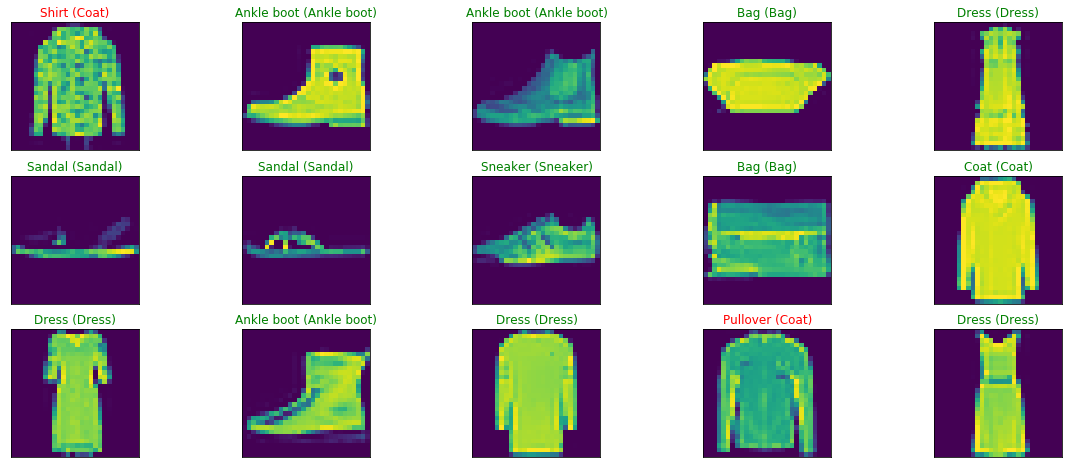

In [13]:
y_hat = model.predict_classes(test_images)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(test_images.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(test_images[index]))
    predict_index = y_hat[index]
    true_index = test_labels[index]
    # Set the title for each image
    ax.set_title("{} ({})".format(class_names[predict_index], 
                                  class_names[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

## Predict on a single image

Let's first see the test image and and its label:

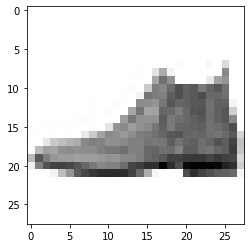

Class: Ankle boot


In [14]:
plt.imshow(test_images[0].squeeze(-1), cmap=plt.cm.binary)
plt.show()
print('Class:', class_names[test_labels[0]])

In [15]:
pred_idx = model.predict_classes(np.expand_dims(test_images[0], 0))[0]
print('Prediction:', class_names[pred_idx])

Prediction: Ankle boot


## Define BentoService for model serving

In [16]:
%%writefile keras_fashion_mnist.py

import numpy as np
from PIL import Image
from bentoml import api, artifacts, env, BentoService
from bentoml.artifact import KerasModelArtifact
from bentoml.handlers import ImageHandler

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

@env(pip_dependencies=['keras', 'tensorflow==1.14.0', 'Pillow', 'numpy'])
@artifacts([KerasModelArtifact('classifier')])
class KerasFashionMnistService(BentoService):
        
    @api(ImageHandler, pilmode='L')
    def predict(self, img):
        img = Image.fromarray(img).resize((28, 28))
        img /= 255.0
        img = np.array(img.getdata()).reshape((1,28,28,1))
        class_idx = self.artifacts.classifier.predict_classes(img)[0]
        return class_names[class_idx]

Overwriting keras_fashion_mnist.py


## Save BentoService to file archive

In [17]:
# 1) import the custom BentoService defined above
from keras_fashion_mnist import KerasFashionMnistService

# 2) `pack` it with required artifacts
mnist_svc = KerasFashionMnistService.pack(classifier=model)

# 3) save your BentoSerivce to file archive
saved_path = mnist_svc.save()

W1014 17:04:47.946959 4335975744 deprecation_wrapper.py:119] From /Users/chaoyuyang/anaconda3/envs/bentoml-dev/lib/python3.7/site-packages/bentoml/artifact/keras_model_artifact.py:90: The name tf.keras.backend.get_session is deprecated. Please use tf.compat.v1.keras.backend.get_session instead.



[2019-10-14 17:05:09,703] INFO - Successfully saved Bento 'KerasFashionMnistService:20191014170448_88D4B9' to path: /Users/chaoyuyang/bentoml/repository/KerasFashionMnistService/20191014170448_88D4B9


## Load BentoService from archive


In [18]:
svc = bentoml.load(saved_path)

svc.predict(test_images[0].squeeze(-1))

[2019-10-14 17:05:10,128] WARNING - Module `keras_fashion_mnist` already loaded, using existing imported module.


W1014 17:05:10.141630 4335975744 deprecation_wrapper.py:119] From /Users/chaoyuyang/anaconda3/envs/bentoml-dev/lib/python3.7/site-packages/bentoml/artifact/keras_model_artifact.py:104: The name tf.keras.backend.set_session is deprecated. Please use tf.compat.v1.keras.backend.set_session instead.



'Ankle boot'

# "pip install" a BentoService archive

BentoML user can directly pip install saved BentoML archive with `pip install $SAVED_PATH`,  and use it as a regular python package.

In [19]:
!pip install {saved_path}

Processing /Users/chaoyuyang/bentoml/repository/KerasFashionMnistService/20191014170448_88D4B9
  Stored in directory: /private/var/folders/ns/vc9qhmqx5dx_9fws7d869lqh0000gn/T/pip-ephem-wheel-cache-3zons_vs/wheels/45/c6/cd/deadc3b6f904fad3a76d71e15d8a469e37def04f583182ceee
Successfully built KerasFashionMnistService
  Found existing installation: KerasFashionMnistService 20191014170128-BB7310
    Uninstalling KerasFashionMnistService-20191014170128-BB7310:
      Successfully uninstalled KerasFashionMnistService-20191014170128-BB7310


In [20]:
# Your bentoML model class name will become packaged name
import KerasFashionMnistService

ms = KerasFashionMnistService.load()
ms.predict(test_images[0].squeeze(-1))

'Ankle boot'

the installed pip package also comes with a CLI tool:

In [21]:
!KerasFashionMnistService predict --input=sample_image.png

Using TensorFlow backend.
2019-10-14 17:05:21.097415: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
W1014 17:05:21.098053 4413451584 deprecation_wrapper.py:119] From /Users/chaoyuyang/anaconda3/envs/bentoml-dev/lib/python3.7/site-packages/bentoml/artifact/keras_model_artifact.py:104: The name tf.keras.backend.set_session is deprecated. Please use tf.compat.v1.keras.backend.set_session instead.

W1014 17:05:21.099946 4413451584 deprecation_wrapper.py:119] From /Users/chaoyuyang/anaconda3/envs/bentoml-dev/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:529: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1014 17:05:21.101047 4413451584 deprecation_wrapper.py:119] From /Users/chaoyuyang/anaconda3/envs/bentoml-dev/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4420: The name tf.random_uniform is deprecated. Please use tf.

# Model Serving via REST API

In your termnial, run the following command to start the REST API server:

In [22]:
!bentoml serve {saved_path}

Using TensorFlow backend.
2019-10-14 17:05:27.026836: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
W1014 17:05:27.027445 4527439168 deprecation_wrapper.py:119] From /Users/chaoyuyang/anaconda3/envs/bentoml-dev/lib/python3.7/site-packages/bentoml/artifact/keras_model_artifact.py:104: The name tf.keras.backend.set_session is deprecated. Please use tf.compat.v1.keras.backend.set_session instead.

W1014 17:05:27.029629 4527439168 deprecation_wrapper.py:119] From /Users/chaoyuyang/anaconda3/envs/bentoml-dev/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:529: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1014 17:05:27.030858 4527439168 deprecation_wrapper.py:119] From /Users/chaoyuyang/anaconda3/envs/bentoml-dev/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4420: The name tf.random_uniform is deprecated. Please use tf.

Test sending request to API Server from terminal:

```bash
curl -X POST "http://127.0.0.1:5000/predict" -F image=@sample_image.png
```

or:

```bash
curl -X POST "http://127.0.0.1:5000/predict" -H "Content-Type: image/png" --data-binary @sample_image.png
```

## Containerize REST API server with Docker

** _Make sure you have `docker` installed, note that it is not available when running in Google Colaboratory_

In [23]:
!cd {saved_path} && docker build -t keras-fashion-mnist .

Sending build context to Docker daemon  5.018MB
Step 1/12 : FROM continuumio/miniconda3
 ---> 4a51de2367be
Step 2/12 : ENTRYPOINT [ "/bin/bash", "-c" ]
 ---> Using cache
 ---> 3794be382825
Step 3/12 : EXPOSE 5000
 ---> Using cache
 ---> 291cb3652304
Step 4/12 : RUN set -x      && apt-get update      && apt-get install --no-install-recommends --no-install-suggests -y libpq-dev build-essential      && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> c4f57518b703
Step 5/12 : RUN conda update conda -y       && conda install pip numpy scipy       && pip install gunicorn six
 ---> Using cache
 ---> 2be0410836d6
Step 6/12 : COPY . /bento
 ---> f867e915b1cf
Step 7/12 : WORKDIR /bento
 ---> Running in 8a0f631f7be2
Removing intermediate container 8a0f631f7be2
 ---> 422fc8ea0d9e
Step 8/12 : RUN conda env update -n base -f /bento/environment.yml
 ---> Running in ff571cc5e594
Solving environment: ...working... done
Ran pip subprocess with arguments:
['/opt/conda/bin/python', '-m', 'pip', 'instal

Removing intermediate container ff571cc5e594
 ---> fcf38ecd1675
Step 9/12 : RUN pip install -r /bento/requirements.txt
 ---> Running in 12e3f24e316c


  Created wheel for pyyaml: filename=PyYAML-5.1.2-cp37-cp37m-linux_x86_64.whl size=44103 sha256=4e4494ffee6a1f2ae11e125d9d4721e47d972aa825e75033ccb7ee80fa0b6a90
  Stored in directory: /root/.cache/pip/wheels/d9/45/dd/65f0b38450c47cf7e5312883deb97d065e030c5cca0a365030
  Created wheel for wrapt: filename=wrapt-1.11.2-cp37-cp37m-linux_x86_64.whl size=76116 sha256=4d5e287b861f98ea0ada5e8c9e5dbe7b770627432188511e81ccc86ab31a3736
  Stored in directory: /root/.cache/pip/wheels/d7/de/2e/efa132238792efb6459a96e85916ef8597fcb3d2ae51590dfd
  Created wheel for absl-py: filename=absl_py-0.8.1-cp37-none-any.whl size=121167 sha256=65d764c71e876c7ed3c423a9157db02cd3e0dd79d71e03dcbcb62fb3ce0e36fc
  Stored in directory: /root/.cache/pip/wheels/a7/15/a0/0a0561549ad11cdc1bc8fa1191a353efd30facf6bfb507aefc
  Created wheel for termcolor: filename=termcolor-1.1.0-cp37-none-any.whl size=4832 sha256=dc56d5782cce20b8a05f555b1a46e268f76931c49e32df61dc0cacac7febda89
  Stored in directory: /root/.cache/pip/wheels/7

In [ ]:
!docker run -p 5000:5000 keras-fashion-mnist

[2019-10-15 00:07:35 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2019-10-15 00:07:35 +0000] [1] [INFO] Listening at: http://0.0.0.0:5000 (1)
[2019-10-15 00:07:35 +0000] [1] [INFO] Using worker: sync
[2019-10-15 00:07:35 +0000] [10] [INFO] Booting worker with pid: 10
[2019-10-15 00:07:35 +0000] [11] [INFO] Booting worker with pid: 11
[2019-10-15 00:07:35 +0000] [12] [INFO] Booting worker with pid: 12
2019-10-15 00:07:36.763037: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-10-15 00:07:36.768014: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2904000000 Hz
2019-10-15 00:07:36.768579: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55ea2249fca0 executing computations on platform Host. Devices:
2019-10-15 00:07:36.768715: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
/opt/conda/lib/python



2019-10-15 00:07:36.967970: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.
2019-10-15 00:07:37.069231: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.
2019-10-15 00:07:37.071228: W tensorflow/compiler/jit/ma